In [1]:
from math import gcd 
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
from datetime import datetime
import copy as cp

import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error
import qiskit.ignis.verification.randomized_benchmarking as rb

qiskit.__version__, sys.version

C:\Users\Timo\AppData\Local\Temp\ipykernel_42808\213096259.py:15: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.randomized_benchmarking as rb


('0.23.0',
 '3.8.16 (default, Jan 17 2023, 22:25:28) [MSC v.1916 64 bit (AMD64)]')

# Library

In [295]:
def filter_same_n_cnot(rb_circs):
    rb_circs_filtered = []
    n_clif_vec = len(rb_circs)
    for i in range(0, n_clif_vec):
        circs_i = []

        n_cnots = [get_n_cx(c) for c in rb_circs[i]]
        most_common = max(set(n_cnots), key = n_cnots.count)
        n_cnots_target = most_common
                
        filtered = filter(lambda c: get_n_cx(c) == n_cnots_target, rb_circs[i])
        rb_circs_filtered.append(list(filtered))
    return rb_circs_filtered

def clip_same_n_rand(rb_circs):
    n_rand = [len(circs) for circs in rb_circs]
    min_n = np.min(n_rand)
    
    rb_circs_out = []
    
    for i in range(0, len(rb_circs)):
        rb_circs_rand = []
        for j in range(0, min_n):
            rb_circs_rand.append(rb_circs[i][j])
        rb_circs_out.append(rb_circs_rand)

    return rb_circs_out

def calc_cx(rb_circs):
    # calculate number of cnots per xdata step
    arr = np.zeros((len(rb_circs),len(rb_circs[0])))
    for i in range(0, len(rb_circs)):
        for j in range(0, len(rb_circs[0])):
            arr[i,j] = get_n_cx(rb_circs[i][j])
    return arr

def calc_1q(rb_circs):
    # calculate number of cnots per xdata step
    arr = np.zeros((len(rb_circs),len(rb_circs[0])))
    for i in range(0, len(rb_circs)):
        for j in range(0, len(rb_circs[0])):
            arr[i,j] = get_n_1q_rot(rb_circs[i][j])
    return arr

def get_n_cx(circ):
    if type(circ) == list:
        # after conversion to qudi format
        return np.sum([el[0][0]=='cx' for el in circ[1]])
    
    return np.sum([el[0].name=='cx' for el in circ.data])

def get_n_1q_rot(circ, basis_gates=['ry', 'rx']):
    if type(circ) == list:
        # after conversion to qudi format
        return np.sum([el[0][0] in basis_gates for el in circ[1]])
    
    return np.sum([el[0].name in basis_gates for el in circ.data])


def is_interleaved(rb_opts):
    if 'interleaved_gates' not in rb_opts:
        return False
    return rb_opts['interleaved_gates'] != []

def circuit_step_2_qubit_idx(cstep, swap_qubits=False):
    qregister = cstep[1]
    if len(qregister) == 2:
        return [0,1]
    elif len(qregister) == 1:
        reg_str = str(qregister[0])
        if ", 1" in reg_str:
            return [1] if not swap_qubits else [0]
        elif ", 0" in reg_str:
            return [0] if not swap_qubits else [1]
    elif len(qregister) > 2:
        raise NotImplementedError

def circuit_step_2_gatestr(cstep):
    return cstep[0].name, [float(p) for p in cstep[0].params]

def circuit_2_step_list(circ, qubit_idx=0, swap_qubits=False):
    gate_strs, on_nv = [],[]
    for step in circ.data:
         gate_strs.append(circuit_step_2_gatestr(step))
         on_nv.append(circuit_step_2_qubit_idx(step, swap_qubits=swap_qubits))
    
    step_list = list(zip(gate_strs, on_nv))
    #return step_list
    return [step for step in step_list if qubit_idx in step[1]]

def serialize_step_list(steps_q0, steps_q1):
    # todo: seems over-complicated, but works
    ser_list = []
    
    idx_0, idx_1 = 0, 0
    while not (idx_0==len(steps_q0) and idx_1==len(steps_q1)):   
        is_end_0, is_end_1 = False, False
        is_2q_0, is_2q_1 = False, False
        try:
            is_2q_0 = len(steps_q0[idx_0][1]) == 2
        except IndexError:
            is_end_0 = True
        try:
            is_2q_1 = len(steps_q1[idx_1][1]) == 2
        except IndexError:
            is_end_1 = True
        
        #print(f"Now list: {ser_list}. \nEnd: {is_end_0}, {is_end_1}, 2q: {is_2q_0}, {is_2q_1}")
        try:
            if (not is_2q_0) and (not is_2q_1) and (not is_end_0) and (not is_end_1):
                ser_list.append(steps_q0[idx_0])
                ser_list.append(steps_q1[idx_1])
                idx_0 += 1
                idx_1 += 1

            elif (is_2q_0) and (not is_2q_1) and (not is_end_1):
                ser_list.append(steps_q1[idx_1])
                idx_1 += 1

            elif (not is_2q_0) and (is_2q_1) and (not is_end_0):
                ser_list.append(steps_q0[idx_0])
                idx_0 += 1

            elif (is_2q_0) and (is_2q_1):
                ser_list.append(steps_q0[idx_0])
                idx_0 += 1
                idx_1 += 1
            elif is_end_0:
                ser_list.append(steps_q1[idx_1])
                idx_1 += 1
            elif is_end_1:
                ser_list.append(steps_q0[idx_0])
                idx_0 += 1
            else:
                raise RuntimeError(f"Failed at idxs {idx_0}, {idx_1}")
                
        except IndexError:
            raise IndexError(f"Failed at idxs {idx_0}, {idx_1}")
        
            
    return ser_list



0

0

# Create random benchmarking list


In [280]:
params = {}

# number of qubits
params['n_qubits'] = 2
params['force_n_cx_const'] = True

rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [i for i in range(1,10)]
#rb_opts['length_vector'] = [2,4,8,16,32,48,64,96,128,144]
# Number of seeds (random sequences)
rb_opts['nseeds'] = 50
# Default pattern
rb_opts['rb_pattern'] = [[0,1]] if params['n_qubits']==2 else [[0]]
# benchmark a specific gate
#rb_opts['interleaved_gates'] = [[['x']]]#[['cx 0 1']]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

# transpose rb_circ st 2nd index is random index
rb_circs = list(map(list, zip(*rb_circs)))

if params['force_n_cx_const']:
    rb_circs = filter_same_n_cnot(rb_circs) 
    rb_circs = clip_same_n_rand(rb_circs)

rb_circs_orig = cp.deepcopy(rb_circs)

# keep copy with original list order for simulation 
rb_circs_orig = list(map(list, zip(*rb_circs_orig)))
rb_circs_native = []

now = datetime.now() # current date and time
params['timestamp'] = now.strftime("%Y%m%d-%H%M-%S")
params['qiskit_version'] = qiskit.__version__
params['rb_options'] = rb_opts

params

{'n_qubits': 2,
 'force_n_cx_const': True,
 'timestamp': '20230202-1815-55',
 'qiskit_version': '0.23.0',
 'rb_options': {'length_vector': [1, 2, 3, 4, 5, 6, 7, 8, 9],
  'nseeds': 50,
  'rb_pattern': [[0, 1]]}}

In [252]:
circ = rb_circs[0][1]
circ, get_n_cx(circ)

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x1f12a0885e0>, 4)

In [281]:
n_rand = [len(circs) for circs in rb_circs]
n_rand
#clip_same_n_rand(rb_circs_f)

[9, 9, 9, 9, 9, 9, 9, 9, 9]

In [282]:
get_n_1q_rot(rb_circs[0][0])

0

In [283]:
calc_cx(rb_circs), calc_1q(rb_circs)  # doto, calc_1q is broken

(array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
        [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.],
        [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.],
        [ 9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.],
        [10., 10., 10., 10., 10., 10., 10., 10., 10.],
        [12., 12., 12., 12., 12., 12., 12., 12., 12.],
        [13., 13., 13., 13., 13., 13., 13., 13., 13.],
        [14., 14., 14., 14., 14., 14., 14., 14., 14.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [284]:
# count mean, median Cnots per idx_cliff
np.mean(calc_cx(rb_circs), axis=1), np.median(calc_cx(rb_circs), axis=1)

(array([ 2.,  4.,  7.,  8.,  9., 10., 12., 13., 14.]),
 array([ 2.,  4.,  7.,  8.,  9., 10., 12., 13., 14.]))

In [285]:
# count mean, median 1qs per idx_cliff
np.mean(calc_1q(rb_circs), axis=1), np.median(calc_1q(rb_circs), axis=1)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [288]:
circ = rb_circs[0][-1]  # indices: n_order, m_random
circ.draw()


┌─────┐┌───┐     ┌───┐┌───┐ ░ ┌─────┐┌───┐     ┌───┐┌───┐┌─┐   
qr_0: ┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├┤M├───
      ├─────┤├───┤┌─┴─┐└───┘└───┘ ░ └─────┘└───┘┌─┴─┐├───┤├───┤└╥┘┌─┐
qr_1: ┤ Sdg ├┤ H ├┤ X ├───────────░─────────────┤ X ├┤ H ├┤ S ├─╫─┤M├
      └─────┘└───┘└───┘           ░             └───┘└───┘└───┘ ║ └╥┘
cr: 2/══════════════════════════════════════════════════════════╩══╩═
                                                                0  1

The defualt gate set used is by qiskit convention (X,Y,Sdg,H,CX). We transpile to a somewhat more useful gate set for NV experiment (1, pi2_x, pi2_y, CNOT).

In [289]:

for circ_list in rb_circs:
    rb_i = []
    for circ_in in circ_list:
        rb_i.append(transpile(circ_in, basis_gates=['id', 'ry', 'rx', 'cx']) )
    rb_circs_native.append(cp.deepcopy(rb_i))

In [290]:

circ = rb_circs_native[0][3]
circ.draw()


global phase: π
      ┌─────────┐┌─────────┐ ┌─────────┐       ░      ┌─────────┐┌─────────┐»
qr_0: ┤ Rx(π/2) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├───■───░───■──┤ Rx(π/2) ├┤ Ry(π/2) ├»
      ├─────────┤├─────────┴┐├─────────┴┐┌─┴─┐ ░ ┌─┴─┐├─────────┤├─────────┤»
qr_1: ┤ Rx(π/2) ├┤ Ry(-π/2) ├┤ Rx(-π/2) ├┤ X ├─░─┤ X ├┤ Rx(π/2) ├┤ Ry(π/2) ├»
      └─────────┘└──────────┘└──────────┘└───┘ ░ └───┘└─────────┘└─────────┘»
cr: 2/══════════════════════════════════════════════════════════════════════»
                                                                            »
«      ┌─────────┐ ┌─┐   
«qr_0: ┤ Rx(π/2) ├─┤M├───
«      ├─────────┴┐└╥┘┌─┐
«qr_1: ┤ Rx(-π/2) ├─╫─┤M├
«      └──────────┘ ║ └╥┘
«cr: 2/═════════════╩══╩═
«                   0  1

In [232]:
circ.data[0][0].params

[-1.5707963267948966]

## Simulate

In [270]:
# Create a new circuit without the measurement
qregs = rb_circs_orig[0][1].qregs
cregs = rb_circs_orig[0][1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs_orig[0][-1][0:-params['n_qubits']]:
    qc.data.append(i)
    
qc

sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

In [271]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.03

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs_orig):
    #print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    #print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    #print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
    
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title(f"{params['n_qubits']}Q RB, interleaved: {rb_opts['interleaved_gates']}", fontsize=18)

plt.show()

StopIteration: 

## Serialize to non-parallel qubit operations

Don't do 1q operations in parallel, but step by step.

In [291]:
# chose a circ
idx_order, idx_circ = 1, 1
circ = rb_circs_native[idx_order][idx_circ]

# swap qubit, as qiskit traspiles to c1not2. We want c2not1.
steps_q0, steps_q1 = circuit_2_step_list(circ, qubit_idx=0, swap_qubits=True), circuit_2_step_list(circ, qubit_idx=1, swap_qubits=True)
serialize_step_list(steps_q0, steps_q1)

[(('rx', [-1.5707963267948983]), [0]),
 (('rx', [-1.5707963267948983]), [1]),
 (('cx', []), [0, 1]),
 (('ry', [1.5707963267948966]), [0]),
 (('ry', [1.5707963267948966]), [1]),
 (('rx', [1.5707963267948966]), [0]),
 (('rx', [1.5707963267948966]), [1]),
 (('cx', []), [0, 1]),
 (('rx', [-1.5707963267948966]), [1]),
 (('ry', [-1.5707963267948966]), [1]),
 (('barrier', []), [0, 1]),
 (('ry', [-1.5707963267948968]), [0]),
 (('rx', [-1.5707963267948966]), [1]),
 (('ry', [3.141592653589793]), [1]),
 (('cx', []), [0, 1]),
 (('rx', [-1.5707963267948966]), [0]),
 (('rx', [-1.5707963267948966]), [1]),
 (('ry', [-1.5707963267948966]), [0]),
 (('ry', [-1.5707963267948966]), [1]),
 (('barrier', []), [0, 1]),
 (('rx', [-1.5707963267948966]), [1]),
 (('ry', [-1.5707963267948966]), [1]),
 (('cx', []), [0, 1]),
 (('rx', [1.5707963267948966]), [0]),
 (('ry', [1.5707963267948966]), [1]),
 (('measure', []), [0]),
 (('rx', [3.141592653589793]), [1]),
 (('measure', []), [1])]

## Save to file

Iterate over (converted to native gates) gate sequence and create a qudi compatible sequence as a json file.

In [292]:
qudi_gates = []
idx = 0


n_seqs = len(rb_circs_native[0])*len(rb_circs_native)
for idx_cl, circ_list in enumerate(rb_circs_native):
    circs_i = []
    for idx_r, circ in enumerate(circ_list):
        #circs_i.append()
        # swap qubit, as qiskit traspiles to c1not2. We want c2not1.
        steps_q0 = circuit_2_step_list(circ, qubit_idx=0, swap_qubits=True)
        steps_q1 = circuit_2_step_list(circ, qubit_idx=1, swap_qubits=True)
        
        idx_dict = {"idx_info":{"n_cliff": rb_opts['length_vector'][idx_cl],
                    "idx_cliff": idx_cl,
                    "idx_random": idx_r}}
        params_dict = {"script params": params}
        
        header = f"### Benchmark Sequence {idx+1}/{n_seqs} ###\n"
        header += f"# {json.dumps(idx_dict)}"
        header += f"# {json.dumps(params)}"
        header += f"# Columns: operation | params | idx_qubit\n"

        
        
        steps = [header]
        steps.append(serialize_step_list(steps_q0, steps_q1))
        
        circs_i.append(steps)
        idx += 1
        
    qudi_gates.append(circs_i)
    

In [293]:
rb_circs_native[5][6]

Perform the saving

In [296]:
import json

fname = f"{params['timestamp']}_rb_seq_{params['n_qubits']}q"
if is_interleaved(rb_opts):
    fname += "_int"
if params['force_n_cx_const']:
    fname += "_ncxfix"
    
fname += ".json"
    
with open(fname, 'w') as f:
    json.dump(qudi_gates, f, indent=None)
fname

'20230202-1815-55_rb_seq_2q_ncxfix.json'

Load saved file to check.

In [297]:
#fname = '20230127-1553-55_rb_seq_2q.json'
with open(fname) as f:
    qudi_gates = json.load(f)
    
qudi_gates[0][0]

['### Benchmark Sequence 1/81 ###\n# {"idx_info": {"n_cliff": 1, "idx_cliff": 0, "idx_random": 0}}# {"n_qubits": 2, "force_n_cx_const": true, "timestamp": "20230202-1815-55", "qiskit_version": "0.23.0", "rb_options": {"length_vector": [1, 2, 3, 4, 5, 6, 7, 8, 9], "nseeds": 50, "rb_pattern": [[0, 1]]}}# Columns: operation | params | idx_qubit\n',
 [[['rx', [1.5707963267948966]], [0]],
  [['rx', [3.141592653589793]], [1]],
  [['ry', [1.5707963267948966]], [0]],
  [['cx', []], [0, 1]],
  [['rx', [-1.5707963267948966]], [0]],
  [['rx', [-1.5707963267948966]], [1]],
  [['ry', [-1.5707963267948966]], [0]],
  [['ry', [-1.5707963267948966]], [1]],
  [['barrier', []], [0, 1]],
  [['ry', [1.5707963267948966]], [0]],
  [['ry', [1.5707963267948966]], [1]],
  [['rx', [1.5707963267948966]], [0]],
  [['rx', [1.5707963267948966]], [1]],
  [['cx', []], [0, 1]],
  [['ry', [-1.5707963267948966]], [0]],
  [['rx', [3.141592653589793]], [1]],
  [['rx', [-1.5707963267948966]], [0]],
  [['measure', []], [1]],

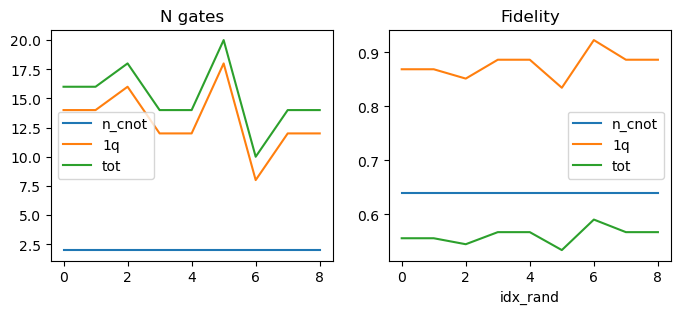

array([14, 14, 16, 12, 12, 18,  8, 12, 12])

In [298]:
err_rate_1q = 0.99
err_rate_2q = 0.8

idx_cliff = 0
ys_cx, ys_1q = [], []
for idx_rand, circ in enumerate(qudi_gates[idx_cliff]):
    y_cx, y_1q = get_n_cx(circ), get_n_1q_rot(circ)
    ys_cx.append(y_cx)
    ys_1q.append(y_1q)
    
ys_cx, ys_1q = np.asarray(ys_cx), np.asarray(ys_1q)

plt.figure(figsize=(8,3))
plt.subplot(121)

plt.plot(ys_cx, label='n_cnot')
plt.plot(ys_1q, label='1q')
plt.plot(np.asarray(ys_1q)+np.asarray(ys_cx), label='tot')
plt.title("N gates")
plt.legend()

plt.subplot(122)
plt.plot(err_rate_2q**ys_cx, label='n_cnot')
plt.plot(err_rate_1q**ys_1q, label='1q')
plt.plot((err_rate_1q**ys_1q * err_rate_2q**ys_cx)/1, label='tot')
plt.title("Fidelity")
plt.legend()

plt.xlabel("idx_rand")
plt.show()

ys_1q

In [322]:
err_rate_1q**ys_cx, err_rate_2q**ys_cx

(array([0.96059601, 0.96059601, 0.96059601, 0.9801    , 0.96059601,
        0.96059601, 0.96059601, 0.9801    , 0.9801    , 1.        ]),
 array([0.4096, 0.4096, 0.4096, 0.64  , 0.4096, 0.4096, 0.4096, 0.64  ,
        0.64  , 1.    ]))

In [303]:
qudi_gates[idx_cliff][0][1]

[[['rx', [1.5707963267948966]], [0]],
 [['rx', [3.141592653589793]], [1]],
 [['ry', [1.5707963267948966]], [0]],
 [['cx', []], [0, 1]],
 [['rx', [-1.5707963267948966]], [0]],
 [['rx', [-1.5707963267948966]], [1]],
 [['ry', [-1.5707963267948966]], [0]],
 [['ry', [-1.5707963267948966]], [1]],
 [['barrier', []], [0, 1]],
 [['ry', [1.5707963267948966]], [0]],
 [['ry', [1.5707963267948966]], [1]],
 [['rx', [1.5707963267948966]], [0]],
 [['rx', [1.5707963267948966]], [1]],
 [['cx', []], [0, 1]],
 [['ry', [-1.5707963267948966]], [0]],
 [['rx', [3.141592653589793]], [1]],
 [['rx', [-1.5707963267948966]], [0]],
 [['measure', []], [1]],
 [['measure', []], [0]]]

In [304]:
qudi_gates[idx_cliff][1][1]

[[['rx', [3.141592653589793]], [0]],
 [['rx', [-1.5707963267948966]], [1]],
 [['ry', [1.5707963267948961]], [1]],
 [['cx', []], [0, 1]],
 [['rx', [-1.5707963267948966]], [0]],
 [['ry', [1.5707963267948966]], [1]],
 [['ry', [-1.5707963267948966]], [0]],
 [['rx', [1.5707963267948966]], [1]],
 [['barrier', []], [0, 1]],
 [['ry', [1.5707963267948966]], [0]],
 [['rx', [-1.5707963267948966]], [1]],
 [['rx', [1.5707963267948966]], [0]],
 [['ry', [-1.5707963267948966]], [1]],
 [['cx', []], [0, 1]],
 [['rx', [3.141592653589793]], [0]],
 [['ry', [-1.5707963267948966]], [1]],
 [['measure', []], [0]],
 [['rx', [1.5707963267948966]], [1]],
 [['measure', []], [1]]]